# Behavioral Cloning - Self-Driving Car ND Project

## Introduction

In this project, a technique called end-to-end learning will be discussed. Using a provided simulator, I'll record driving data according to my behavior behind the wheel, and then I'll train a deep neural network to mimic my way of driving and learn how to drive in the simulator by itself.

## Data collection

The simulator collects data from three cameras mounted on the windshield of the car (left, center and right cameras). It also records the steering angle associated with each set of images and it records approximately 10 frames per second per camera.

Training the network with only regular driving data might not be sufficient, because the network might never learn how to recover from a mistake. One way of improving this issue is to augment the data by using images from the left and right cameras and add corrective biases to their associated steering angle (this method was used is this NVIDIA paper: http://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf).

Another method, which was used here, is to collect data while driving somewhat irregularly. Data was recorded with the car drinving on the edges of the track and also going in the reverse direction of the track (to balance the total number of left and right turns).

## Data visualization

After analyzing the collected data, I noticed that, since the simulator was controlled with a keyboard, the steering data had some very discrete variations. To remedy this issue, I decided to apply a gaussian filter to the data to make it smoother. The window size for the filter was set to 20 samples (i.e. approximately 2 seconds). The results are shown below.

In [1]:
### Import necessary packages
import numpy as np
import pandas as pd
import cv2
from os.path import basename
import json
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
### Convolution of a 1D signal with a gaussian filter of a given window length
def smooth(curve, window_len):
    
    # Gaussian parameters
    sigma = 1.
    mu = 0.
    # Setting up 'x', guarantees the gaussian window 'w' is centered and
    # independs on the value of mu and sigma
    x = np.arange(mu - 3*sigma, mu + 3.1*sigma, sigma/(window_len/6.))
    w = (np.exp((-1.*(x - mu)**2)/(2*sigma**2)))*(1./(np.sqrt(2*np.pi*sigma**2))) 

    y = np.convolve(w/w.sum(), curve, mode='same')
    return y

### Read the dataset and apply the 'smooth' function on its steering data
def smooth_dataset(file_name):
    dataset = pd.read_csv(file_name, header=0)
    dataset['steering'] = smooth(dataset['steering'][:], window_len=20)
    return dataset

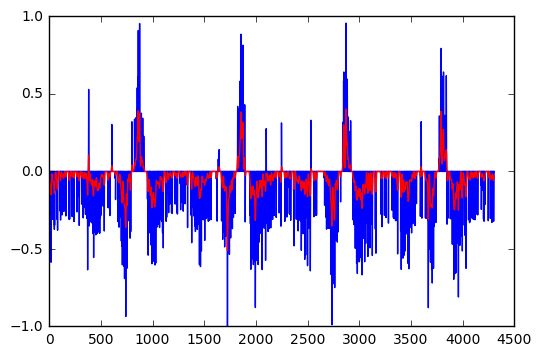

In [3]:
### Visualize the results before and after the application of the gaussian filter
### on one of the collected datasets
example = pd.read_csv('track1/full_center2/driving_log.csv', header=0)

plt.plot(example['steering'], 'b', smooth(example['steering'][:], window_len=20), 'r')

In [4]:
### Load all the collected data
c_rev = smooth_dataset('track1/full_center_rev1/driving_log.csv')
c = smooth_dataset('track1/full_center1/driving_log.csv')
tL_rev = smooth_dataset('track1/full_toLeft_rev1/driving_log.csv')
tL = smooth_dataset('track1/full_toLeft1/driving_log.csv')
tR_rev = smooth_dataset('track1/full_toRight_rev1/driving_log.csv')
tR = smooth_dataset('track1/full_toRight1/driving_log.csv')
c2 = smooth_dataset('track1/full_center2/driving_log.csv')
c_rev2 = smooth_dataset('track1/full_center_rev2/driving_log.csv')
tL2 = smooth_dataset('track1/full_toLeft2/driving_log.csv')
tL_rev2 = smooth_dataset('track1/full_toLeft_rev2/driving_log.csv')
tR2 = smooth_dataset('track1/full_toRight2/driving_log.csv')
tR_rev2 = smooth_dataset('track1/full_toRight_rev2/driving_log.csv')

Below, it's possible to see samples of the collected frames from different datasets to better understand the procedures explained in the *Data Collection* section.

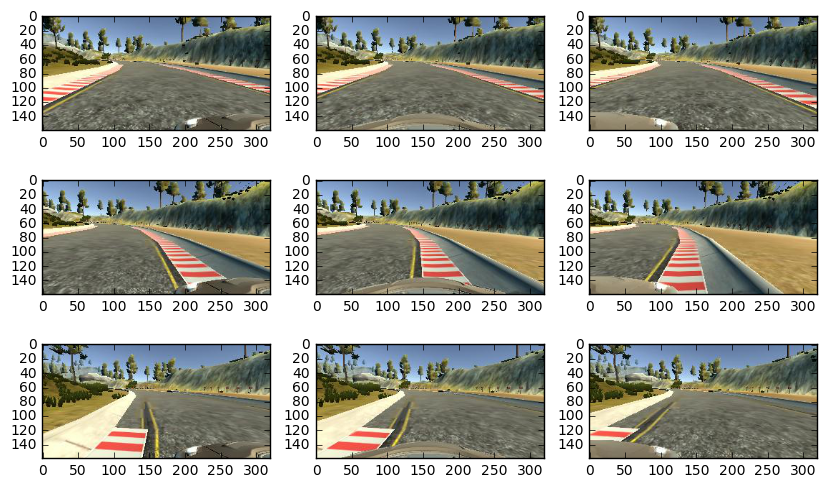

In [5]:
def read_img(dataset, col_name):
    img = cv2.imread('IMG/' + basename(dataset[col_name][0]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

dataset_list = [c, tL, tR]
plt.figure(figsize=(10, 6))
for i in range(3):
    dataset = dataset_list[i]
    img = read_img(dataset, 'left')
    plt.subplot(331 + 3*i)
    plt.imshow(img)
    img = read_img(dataset, 'center')
    plt.subplot(332 + 3*i)
    plt.imshow(img)
    img = read_img(dataset, 'right')
    plt.subplot(333 + 3*i)
    plt.imshow(img)

## Data preparation

Since the end goal here is to design an end-to-end deep neural network to mimic my driving behavior, it's necessary to prepare the data into an array of images and an array of their corresponding steering angles. For that, the following functions were developed.

In [6]:
### Read the original image, crop and resize it to a 32x32 format
def read_images(dataset, bias=0):
    img_data = np.empty((dataset.shape[0], 32, 32, 3))
    for i in range(dataset.shape[0]):
        img = cv2.imread('IMG/' + basename(dataset[i]))
        img = cv2.resize(img[80:120, 0:320, :],
                         None, fx=32./320., fy=32./40.,
                         interpolation=cv2.INTER_AREA)
        img_data[i, :, :, :] = img
    return img_data

### Load images and corresponding steering angles from given dataframe
def load_dataset_from_log(driving_log_df):
    center_img, center_steering = load_col_from_log(driving_log_df, col_name='center')
    left_img, left_steering = load_col_from_log(driving_log_df, col_name='left', bias=0.15)
    right_img, right_steering = load_col_from_log(driving_log_df, col_name='right', bias=-0.15)
    img_data = np.r_[center_img, left_img, right_img]
    steering_data = np.r_[center_steering,
                          left_steering,
                          right_steering]
    return img_data, steering_data

### Load images from a single camera and their corresponding steering
### angles with the appropriate bias from given dataframe
def load_col_from_log(driving_log_df, col_name, bias=0.):
    img_data = read_images(driving_log_df[col_name], bias=bias)
    steering_data = driving_log_df['steering'] + bias
    return img_data, steering_data

The network has to calculate a steering angle for every frame, which means it has to predict approximately 10 steering angles per second. Even at 30 mph (the simulator's top speed), the distance traveled in a tenth of a second is significantly smaller then the full horizon shown in the frame samples above. With that in mind, the images were cropped to *40x320* (originally *160x320*), with an estimation of the distance that would be traveled in the next 0.1 second.

The images were also resized to *32x32* frames, to reduce the number of parameters and to facilitate the usage of squared filters in the convnets involved in the end network.

In [7]:
### Preprocess all the collected data
c_img, c_steering = load_dataset_from_log(c)
c_rev_img, c_rev_steering = load_dataset_from_log(c_rev)

tL_img, tL_steering = load_col_from_log(tL, col_name='center', bias=-0.2)
tL_rev_img, tL_rev_steering = load_col_from_log(tL_rev, col_name='center', bias=-0.2)

tR_img, tR_steering = load_col_from_log(tR, col_name='center', bias=0.2)
tR_rev_img, tR_rev_steering = load_col_from_log(tR_rev, col_name='center', bias=0.2)

c2_img, c2_steering = load_dataset_from_log(c2)
c_rev2_img, c_rev2_steering = load_dataset_from_log(c_rev2)

tL2_img, tL2_steering = load_col_from_log(tL2, col_name='center', bias=-0.2)
tL_rev2_img, tL_rev2_steering = load_col_from_log(tL_rev2, col_name='center', bias=-0.2)

tR2_img, tR2_steering = load_col_from_log(tR2, col_name='center', bias=0.2)
tR_rev2_img, tR_rev2_steering = load_col_from_log(tR_rev2, col_name='center', bias=0.2)

img_train = np.r_[c_img, c_rev_img,
                         tL_img, tL_rev_img,
                         tR_img, tR_rev_img,
                         c2_img, c_rev2_img,
                         tL2_img, tL_rev2_img,
                         tR2_img, tR_rev2_img]
steering_train = np.r_[c_steering, c_rev_steering,
                             tL_steering, tL_rev_steering,
                             tR_steering, tR_rev_steering,
                             c2_steering, c_rev2_steering,
                             tL2_steering, tL_rev2_steering,
                             tR2_steering, tR_rev2_steering]

print(img_train.shape, steering_train.shape)

(52839, 32, 32, 3) (52839,)


From the *Data Visualization* section, it's possible to see that the data is somewhat unbalanced even after the gaussian filter is applied. To try to fix that, the training data was divided in 3 subsets.

In [8]:
img_z = img_train[((steering_train <= 0.1) & (steering_train >= -0.1)), :, :, :]
img_p = img_train[steering_train > 0.1, :, :, :]
img_n = img_train[steering_train < -0.1, :, :, :]
str_z = steering_train[((steering_train <= 0.1) & (steering_train >= -0.1))]
str_p = steering_train[steering_train > 0.1]
str_n = steering_train[steering_train < -0.1]

print(img_z.shape, str_z.shape)
print(img_p.shape, str_p.shape)
print(img_n.shape, str_n.shape)

(15298, 32, 32, 3) (15298,)
(17626, 32, 32, 3) (17626,)
(19915, 32, 32, 3) (19915,)


## Network architecture

The following network architecture was used. The width of the layers were based on powers of 2 (in case the system is optimized, it makes calculations run faster); and the size of the filters were chosen in order to avoid padding in the pooling layer.

Dropout was added in order to avoid overfitting and so was data augmentation (discussed in the next section).

In [9]:
from keras.models import Sequential
from keras.layers.core import Dense, Flatten, Activation, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

# Fix error with TF and Keras
import tensorflow as tf
tf.python.control_flow_ops = tf

model = Sequential()
model.add(Convolution2D(4, 1, 1, border_mode='valid', input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(Convolution2D(8, 5, 5, border_mode='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Convolution2D(8, 1, 1, border_mode='valid'))
model.add(Activation('relu'))
model.add(Convolution2D(16, 3, 3, border_mode='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Convolution2D(16, 1, 1, border_mode='valid'))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3, border_mode='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(1))

Using TensorFlow backend.


## Training the model

To train the model, a generator was used to augment and ballance the data. Three data augmentation strategies were used to prevent the model from overfitting: flipping the image and corresponding steering angle's sign; gamma correction to simulate different brightness conditions; and adding gaussian noise to the images to simulate information loss (so the network doesn't learn to rely on a particular pixel).

In [10]:
### Data augmentation strategies
def preprocess_img(img, steering):
    
    # 50% chance of flipping the image to augment
    # positive data points with negative ones and
    # vice versa
    flip = np.random.uniform(low=-0.5, high=0.5)
    if flip >= 0:
        img = cv2.flip(img, 1)
        steering = -steering
    
    # Gamma correction to augment data with respect
    # to brightness
    img = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2HSV)
    img = img/255.
    gamma = np.random.uniform(low=0.01, high=2.0)
    img[:, :, 2] = img[:, :, 2]**gamma
    img = cv2.cvtColor((img*255.).astype(np.uint8), cv2.COLOR_HSV2RGB)
    
    # Image normalization - guarantees the data
    # has zero mean and std less than 1
    img = img - img.mean()
    img = img/img.max()
    
    # Added gaussian noise to augment data with
    # respect to loss of information
    sigma = np.random.uniform(low=0.001, high=0.01)
    noise = np.random.randn(32, 32, 3)*sigma
    img = img + noise
    return img, steering

### Generator used to augment and ballance the training data
def batch_generator(img0_dataset, steering0_dataset, 
                    imgP_dataset, steeringP_dataset,
                    imgN_dataset, steeringN_dataset,
                    batch_size=1800):
    
    img_batch = np.empty((batch_size, 32, 32, 3))
    steering_batch = np.empty((batch_size,))
    
    while True:
        
        batch_slice = int(batch_size/3)
        
        # Data close to zero
        img0_dataset, steering0_dataset = shuffle(img0_dataset, 
                                                  steering0_dataset)
        for i in range(batch_slice):
            img_batch[i, :, :, :], steering_batch[i] = preprocess_img(img0_dataset[i, :, :, :], steering0_dataset[i])
        
        # Positive data
        imgP_dataset, steeringP_dataset = shuffle(imgP_dataset, 
                                                  steeringP_dataset)
        for i in range(batch_slice, 2*batch_slice):
            i_ = i - batch_slice
            img_batch[i, :, :, :], steering_batch[i] = preprocess_img(imgP_dataset[i_, :, :, :], steeringP_dataset[i_])
        
        # Negative data
        imgN_dataset, steeringN_dataset = shuffle(imgN_dataset, 
                                                  steeringN_dataset)
        for i in range(2*batch_slice, batch_size):
            i_ = i - 2*batch_slice
            img_batch[i, :, :, :], steering_batch[i] = preprocess_img(imgN_dataset[i_, :, :, :], steeringN_dataset[i_])
        
        yield (img_batch, steering_batch)

The model was trained to minimize a *MSE* loss function using an *Adam* optimizer with the default learning rate of 0.001. The trainig lasted 10 epochs with 48,600 samples per epoch and a batch size of 1800 samples. These parameters were fine tuned under random tests.

In [11]:
### Train model to minimize 'mse'
model.compile(loss='mean_squared_error', optimizer='adam')
datagen = batch_generator(img_z, str_z, 
                          img_p, str_p,
                          img_n, str_n)
history = model.fit_generator(datagen, 
                              samples_per_epoch=48600, 
                              nb_epoch=10, 
                              verbose=1)


### Save model parameters
model.save_weights('model.h5')
model_json = model.to_json()
with open('model.json', 'w') as f:
    json.dump(model_json, f)

Epoch 1/10
48600/48600 [==============================] - 94s - loss: 0.0264    
Epoch 2/10
48600/48600 [==============================] - 80s - loss: 0.0177    
Epoch 3/10
48600/48600 [==============================] - 79s - loss: 0.0150    
Epoch 4/10
48600/48600 [==============================] - 83s - loss: 0.0139    
Epoch 5/10
48600/48600 [==============================] - 95s - loss: 0.0132    
Epoch 6/10
48600/48600 [==============================] - 94s - loss: 0.0130    
Epoch 7/10
48600/48600 [==============================] - 89s - loss: 0.0120    
Epoch 8/10
48600/48600 [==============================] - 87s - loss: 0.0116    
Epoch 9/10
48600/48600 [==============================] - 85s - loss: 0.0113    
Epoch 10/10
48600/48600 [==============================] - 85s - loss: 0.0110    


## Testing the model on the tracks

The model was able to successfully complete several laps on the 1st track (where training data was recorded from). On the 2nd track, the model is able to drive through most of the curves, but it fails to complete the U-turns.

For further improvements, data on the 2nd track should be collected and used during training to help with the generalization of the model. I also noted that the model still wiggles a little bit depending on the velocity of the car and the section of the track it is driving through. To correct this issue either better recovering data should be recorded or the data augmentation hyper parameters above need to be fine tuned.